In [1]:
from transformers import MarianMTModel, MarianTokenizer
from tensorly.decomposition import tucker
import tensorly as tl
import torch
import torch.nn as nn
import time
import sacrebleu
import copy


tl.set_backend('pytorch')

In [3]:
!pip install sentencepiece
!pip install sacremoses


In [2]:
def _get_parent_module(model, layer_name):
    layer_name_parts = layer_name.split('.')
    parent_module = model
    for part in layer_name_parts[:-1]:
        parent_module = getattr(parent_module, part)
    return parent_module, layer_name_parts[-1]

In [3]:
class TuckerCompressedLinear(nn.Module):
    def __init__(self, core, factor_left, factor_right, bias=None):
        super(TuckerCompressedLinear, self).__init__()
        self.core = nn.Parameter(core)
        self.factor_left = nn.Parameter(factor_left)
        self.factor_right = nn.Parameter(factor_right)
        self.bias = nn.Parameter(bias) if bias is not None else None

    def forward(self, x):
        # Perform Tucker factorization operations
        x = torch.matmul(x, self.factor_right)    # (N, d_input) x (d_input, r1)
        x = torch.matmul(x, self.core)            # (N, r1) x (r1, r2)
        x = torch.matmul(x, self.factor_left.T)   # (N, r2) x (r2, d_output)
        if self.bias is not None:
            x = x + self.bias
        return x

In [4]:
def compress_model_with_tucker(model, rank):
    for name, layer in model.named_modules():
        if "lm_head" in name:
            continue

        if isinstance(layer, nn.Linear):
            bias = layer.bias.data if layer.bias is not None else None
            
            with torch.no_grad():
                weights = layer.weight.data
                rank_0 = min(rank, weights.shape[0])
                rank_1 = min(rank, weights.shape[1])

                core, factors = tucker(weights, rank=[rank_0, rank_1])

                new_layer = TuckerCompressedLinear(
                    core=core,
                    factor_left=factors[0],
                    factor_right=factors[1],
                    bias=bias
                )
                parent_module, layer_name = _get_parent_module(model, name)
                setattr(parent_module, layer_name, new_layer)
    return model

In [5]:
def translate(model, text, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True)
    outputs = model.generate(**inputs)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def measure_time_and_quality(model, prompt, tokenizer):
    start_time = time.time()
    generated_text = translate(model, prompt, tokenizer)
    generation_time = time.time() - start_time
    return generated_text, generation_time

def measure_memory(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

In [6]:
model_name = "Helsinki-NLP/opus-mt-en-ru"
original_model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

In [ ]:
'''prompt = "The weather is beautiful today."
reference = [
    "Сегодня прекрасная погода.",
    "Погода сегодня чудесная.",
    "Сегодня замечательная погода.",
    "Погода сегодня прекрасная.",
    "Сегодня хорошая погода.",
    "Погода сегодня хорошая.",
    "Сегодня отличная погода.",
    "Погода сегодня отличная.",
    "Погода сегодня прекрасна.",
]'''

prompt = "My heart sank a bit when I went down again the next day and saw him back in the same position again. By now he was slightly more vulnerable and dishevelled than before. He looked cold and hungry and he was shaking a little."
reference = [
    "Моё сердце сжалось, когда я снова спустился на следующий день и увидел его в том же положении. Теперь он выглядел ещё более уязвимым и потрёпанным, чем раньше. Он казался замёрзшим и голодным, и немного дрожал.",
    "На следующий день, спустившись вниз, я снова увидел его в том же состоянии, и моё сердце сжалось. Теперь он выглядел ещё более уязвимым и несчастным. Он замерзал, был голоден и слегка дрожал.",
    "Когда я снова спустился вниз на следующий день и увидел его в той же позе, моё сердце болезненно сжалось. Он выглядел ещё более ослабленным и растрёпанным, чем раньше. Он дрожал, был голоден и явно замёрз.",
    "Моё сердце упало, когда я на следующий день снова увидел его в том же положении. Теперь он выглядел слабее и грязнее. Он, похоже, замерзал, дрожал и выглядел голодным.",
    "Спустившись на следующий день, я заметил, что он всё ещё сидит в той же позе, что и раньше. Моё сердце сжалось от этого зрелища. Он выглядел хуже, чем накануне: ослабленный, голодный и дрожащий от холода.",
    "На следующий день я увидел его снова в том же месте. Моё сердце упало. Он выглядел слабее, голодным и дрожал от холода.",
    "Моё сердце сжалось, когда на следующий день я снова увидел его там же. Он выглядел ещё более уязвимым, грязным и голодным. Он дрожал, словно замерзал.",
    "Когда я спустился на следующий день, он всё ещё сидел на том же месте, и моё сердце болезненно сжалось. Он выглядел слабее и, казалось, замерзал. Он дрожал, и видно было, что он очень голоден.",
    "На следующий день я снова увидел его в том же месте, и мне стало жаль его ещё больше. Он выглядел плохо: слабый, дрожащий, голодный и замёрзший.",
    "На следующий день я снова спустился и увидел его на том же месте. Моё сердце сжалось: он выглядел ещё более голодным, слабым и замёрзшим, чем раньше.",
    "Когда я снова спустился вниз на следующий день, я увидел его в том же положении. Моё сердце сжалось: он был голодным, холодным и слабым.",
    "На следующий день, спустившись, я снова увидел его. Моё сердце упало, потому что он выглядел слабее и замёрзшим. Он дрожал и казался голодным.",
    "Моё сердце сжалось, когда я на следующий день снова увидел его. Он был в той же позе, выглядел слабым, голодным и дрожал от холода.",
    "Когда я на следующий день снова спустился вниз, я увидел его там же. Моё сердце болезненно сжалось. Он выглядел ещё хуже: ослабевший, дрожащий и голодный.",
    "На следующий день я снова увидел его, и мне стало очень жаль. Моё сердце сжалось, потому что он выглядел замёрзшим, дрожал и явно был голоден."
]

'''prompt = """
As we approached the end of Bob’s second week of medication, he was looking a lot brighter. The wound at the back of his leg was healing nicely and the bald and thin patches on his coat had begun to disappear and were being replaced with new, thicker fur. He also seemed happier in his face, his eyes had a more lustrous gleam to them. There was a beautiful, green and yellow glow to them that hadn’t been there before.

He was definitely on the road to recovery, and his boisterousness around the flat was the ultimate proof of it. He had been a whirling dervish, flying around the place since day one, but in the past week or so he’d become even more of a ball of energy. I hadn’t thought it possible. There were times when he would jump and run around the place like some kind of maniac. He would claw furiously at everything and anything he could find, including me.

There were scratches on every wooden surface in the flat. I even had scratches on the back of my hand and arm. I didn’t mind, I knew it wasn’t malicious and that he was only playing.
"""

reference = [
    """
К концу второй недели лечения Боб выглядел намного лучше. Рана на задней лапе заживала, а лысины и тонкие участки на его шерсти начали исчезать, сменяясь новой, более густой шерстью. Он выглядел счастливее, его глаза сияли ярким блеском. В них появилась красивая зелено-желтая искра, которой раньше не было.

Он явно шел на поправку, и его резвость в квартире была лучшим доказательством этого. С самого первого дня он был настоящим вихрем, но за последнюю неделю стал еще более энергичным. Я не думал, что это возможно. Иногда он прыгал и носился по комнате, как настоящий безумец. Он яростно царапал все, что попадалось под лапы, включая меня.

На каждой деревянной поверхности в квартире появились царапины. Даже на тыльной стороне моей руки и предплечья были следы от его когтей. Но мне было все равно, я знал, что он делал это не со зла, а просто играл.
""",
    """
К завершению второй недели лечения Боб выглядел гораздо лучше. Рана на задней лапе хорошо заживала, а залысины и редкие участки шерсти постепенно заменялись густым новым покровом. Он выглядел довольным, его глаза сверкали ярким блеском. В них появился яркий зеленовато-желтый оттенок, который раньше я не замечал.

Было очевидно, что он идет на поправку. Его активность в квартире была лучшим подтверждением этому. С первого дня он был непоседливым, но за последнюю неделю его энергия стала еще больше. Иногда он бегал и прыгал по квартире, словно сумасшедший. Он нещадно царапал все, что попадалось ему на пути, включая меня.

Деревянные поверхности в квартире были испещрены царапинами. Даже на моих руках и запястьях появились следы его когтей. Я не обижался, потому что знал, что он делает это не специально, а просто резвится.
""",
    """
Ближе к концу второй недели лечения Боб начал выглядеть значительно лучше. Рана на задней лапе заживала, а тонкие и залысевшие места на его шерсти начали обрастать густой и новой шерстью. Его лицо выглядело счастливее, а в глазах появился новый яркий блеск. Теперь они светились красивым зеленовато-желтым оттенком, которого раньше не было.

Его выздоровление было очевидным, а его бурная активность в квартире стала тому доказательством. Он был невероятно энергичным с самого начала, но за последнюю неделю стал еще более живым. Иногда он носился по квартире и прыгал, как настоящий маньяк. Он активно царапал все, что попадалось ему под лапы, даже меня.

Вся деревянная мебель в квартире была покрыта царапинами. На тыльной стороне моей руки и предплечья тоже появились следы его когтей. Я не злился, понимая, что он просто играет.
"""
]'''


original_translation, original_time = measure_time_and_quality(original_model, prompt, tokenizer)
original_memory = measure_memory(original_model)



ranks = [512, 430, 400, 362, 340, 320, 300, 280, 256, 128, 64]

compressed_translations = []
compressed_times = []
compressed_memories = []
bleu_scores = []

original_translation, original_time = measure_time_and_quality(original_model, prompt, tokenizer)
original_memory = measure_memory(original_model)
bleu_orig = sacrebleu.corpus_bleu([original_translation], [reference])


print("\Original Results:")
print(f"Original Translation: {original_translation}")
print(f"Original Time: {original_time:.2f} seconds")
print(f"Original Memory: {original_memory}")
print(f"Original BLEU: {bleu_orig.score:.2f}")
print("-" * 40)


for rank in ranks:
    print(f"Processing rank: {rank}")

    compressed_model = copy.deepcopy(original_model)
    compressed_model = compress_model_with_tucker(compressed_model, rank)

    compressed_translation, compressed_time = measure_time_and_quality(compressed_model, prompt, tokenizer)
    compressed_memory = measure_memory(compressed_model)

    bleu_comp = sacrebleu.corpus_bleu([compressed_translation], [reference])

    compressed_translations.append(compressed_translation)
    compressed_times.append(compressed_time)
    compressed_memories.append(compressed_memory)
    bleu_scores.append(bleu_comp.score)

    print(f"Rank: {rank}")
    print(f"Compressed BLEU: {bleu_comp.score:.2f}")
    print(f"Translation: {compressed_translation}")
    print(f"Time: {compressed_time:.2f} seconds")
    print(f"Memory: {compressed_memory}")
    print("-" * 100)

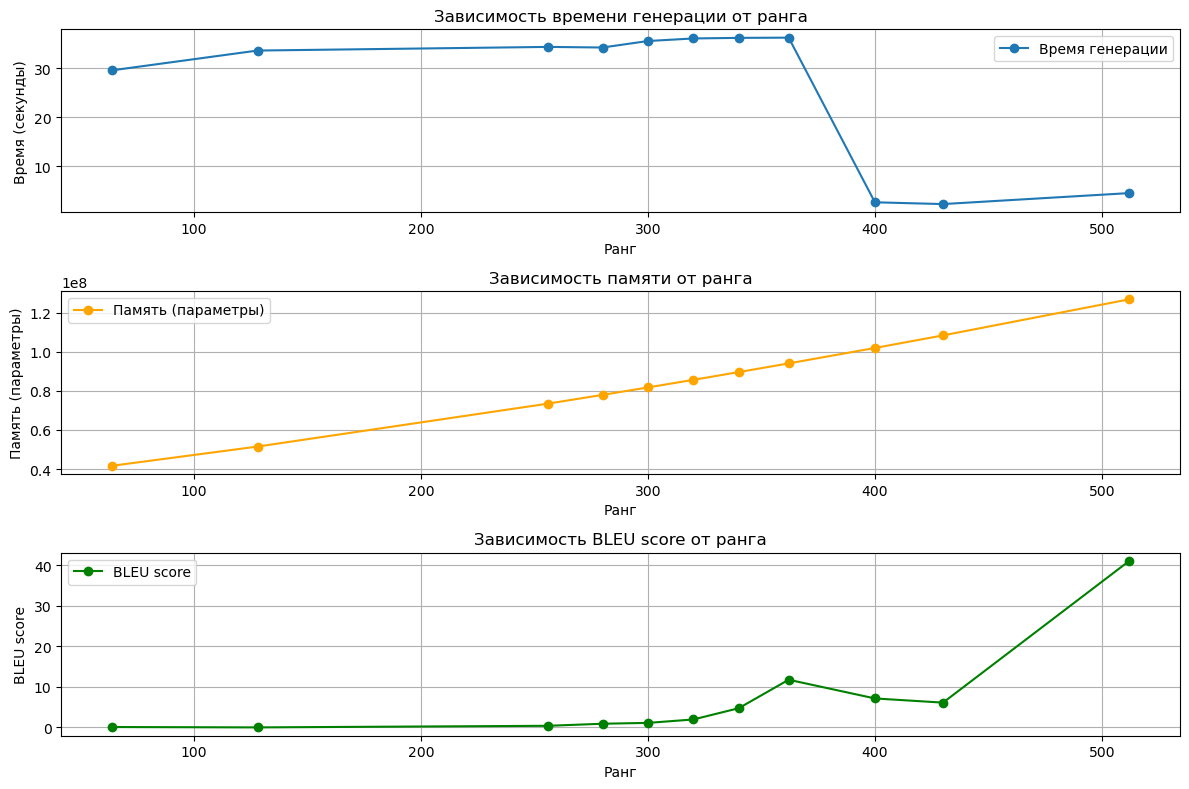

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(ranks, compressed_times, marker='o', label="Время генерации")
plt.xlabel("Ранг")
plt.ylabel("Время (секунды)")
plt.title("Зависимость времени генерации от ранга")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(ranks, compressed_memories, marker='o', color='orange', label="Память (параметры)")
plt.xlabel("Ранг")
plt.ylabel("Память (параметры)")
plt.title("Зависимость памяти от ранга")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(ranks, bleu_scores, marker='o', color='green', label="BLEU score")
plt.xlabel("Ранг")
plt.ylabel("BLEU score")
plt.title("Зависимость BLEU score от ранга")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Подобно CP у Tucker разложения есть много нахваний, например "Three-mode factor analysis", "Three-mode principal component analysis", "N-mode principal components analysis", "Higher-order SVD", "N-mode SVD". 

Разложение Такера это один из видов высокорангового анализа главных компонент. Оно разкладывает тензор в ядро тензора умноженое (или трансформированое) на матрицу вдоль каждой размерности. Например для случая трех размерностей, где $\mathcal{X} \in \mathbb{R}^{I \times J \times K}$ мы имеем

$$
\mathcal{X} \approx \mathcal{G} \times_1 \mathbf{A} \times_2 \mathbf{B} \times_3 \mathbf{C} = 
\sum_{p=1}^{P} \sum_{q=1}^{Q} \sum_{r=1}^{R} g_{pqr} \mathbf{a}_p \circ \mathbf{b}_q \circ \mathbf{c}_r = 
\llbracket \mathcal{G} ; \mathbf{A}, \mathbf{B}, \mathbf{C} \rrbracket. \tag{4.1}
$$

Здесь у нас $ \mathbf{A} \in \mathbb{R}^{I \times P} $, $ \mathbf{B} \in \mathbb{R}^{J \times Q} $ и $ \mathbf{C} \in \mathbb{R}^{K \times R} $ матрицы-факторы, который обычно ортогональны и могут пониматься как основный компоненты по каждому из направлений. Тензор $\mathcal{G} \in \mathbb{R}^{P \times Q \times R}$ называется ядром тензора и его содержание показывает уровень взаимосвязи между различными компонентами. 

Поэлементно:

$$ x_{ijk} \approx \sum_{p=1}^{P} \sum_{q=1}^{Q} \sum_{r=1}^{R} g_{pqr} \mathbf{a}_{ip} \mathbf{b}_{jq} \mathbf{c}_{kr}, для i = 1, ..., I, j = 1, ..., J, k = 1, ..., K$$


<img src="img/tucker_decomp.jpg" alt="My Image" width="800">


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sacrebleu import sentence_bleu

prompts = [
    "The weather is beautiful today.",
    "I love programming in Python.",
    "Artificial intelligence is the future.",
    "Let's go to the park this weekend.",
    "Have you finished your homework?",
]

references_list = [
    ["Сегодня прекрасная погода.", "Погода сегодня чудесная."],
    ["Я люблю программировать на Python.", "Программировать на Python приятно."],
    ["Искусственный интеллект — это будущее.", "Будущее за искусственным интеллектом."],
    ["Давай сходим в парк на выходных.", "Как насчет прогулки в парке в эти выходные?"],
    ["Ты сделал домашнюю работу?", "Домашняя работа закончена?"],
]

ranks = [512, 430, 400, 362, 340, 320, 300, 280, 256, 128, 64]

original_bleu_scores = []
compressed_bleu_scores = {rank: [] for rank in ranks}
translations = []

for prompt, references in zip(prompts, references_list):
    original_translation, _ = measure_time_and_quality(original_model, prompt, tokenizer)
    translations.append(original_translation)
    bleu = sentence_bleu(original_translation, references)
    original_bleu_scores.append(bleu.score)

for rank in ranks:
    compressed_model = compress_model_with_tucker(copy.deepcopy(original_model), rank)
    for prompt, references in zip(prompts, references_list):
        compressed_translation, _ = measure_time_and_quality(compressed_model, prompt, tokenizer)
        translations.append(compressed_translation)
        bleu = sentence_bleu(compressed_translation, references)
        compressed_bleu_scores[rank].append(bleu.score)

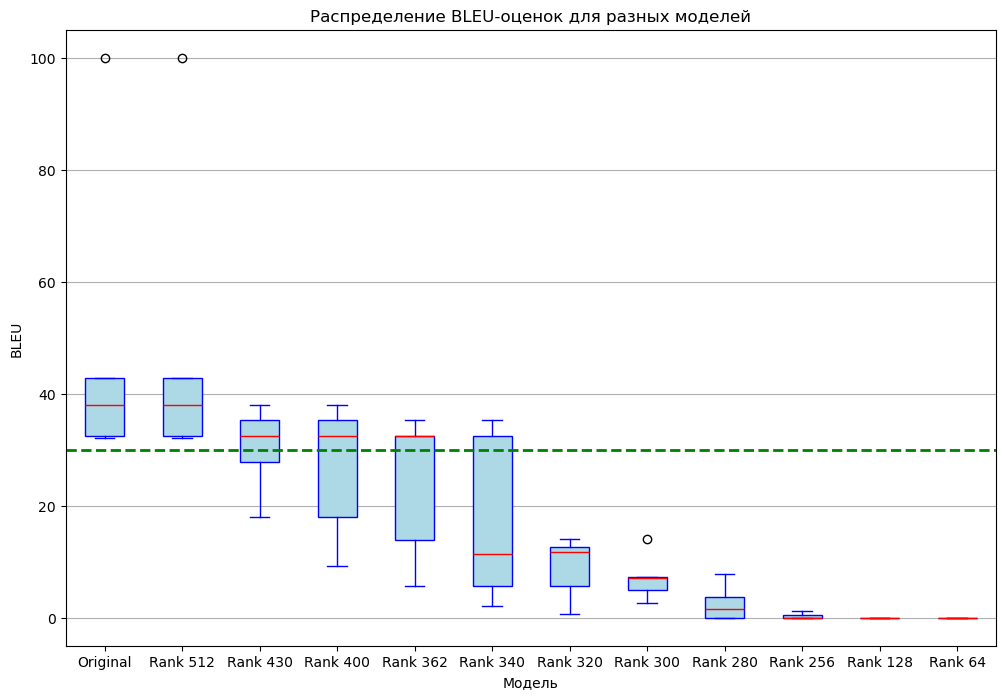

In [10]:
plt.figure(figsize=(12, 8))

plt.boxplot(
    [original_bleu_scores] + [compressed_bleu_scores[rank] for rank in ranks],
    labels=["Original"] + [f"Rank {r}" for r in ranks],
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="blue"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="blue"),
    capprops=dict(color="blue"),
)
plt.xlabel("Модель")
plt.ylabel("BLEU")
plt.title("Распределение BLEU-оценок для разных моделей")
plt.axhline(y=30, color='green', linestyle='--', linewidth=2, label='BLEU = 30')
plt.grid(axis="y")
plt.show()